In [1]:
import argparse
import sys
import pandas as pd
import SimpleITK as sitk
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path

thispath = Path().resolve()
base_path = thispath.parent
sys.path.insert(0, str(base_path))

from utils.metrics import dice_score, rel_abs_vol_dif, avd, haussdorf
from utils.plots import plot_dice, plot_hausorf, plot_ravd, plot_avd

### Define all necessary paths

In [2]:
data_path = base_path / 'data'
test_set_path = data_path / 'test_set'
train_set_path = data_path / 'train_set'
val_set_path = data_path / 'validation_set'
params_path =  base_path / 'elastix' / 'parameter_maps' / 'Par0010'
our_atlas_path = data_path / 'ibsr_atlas'
mni_atlas_path = data_path / 'mni_atlas'

#### Compute the metrics from the results for the train set of the simple segmenters

In [3]:
# Define the paths, experiments we want and cases we want
experiments_path = base_path / 'experiments/simple_segmenters'
savepath = base_path / 'experiments/simple_segmenters'
exp_names = [
    'multi_atlas_staple',
    'multi_atlas_cosine', 'multi_atlas_mse', 'tissue_prob_maps_ibsr18', 'tissue_models_tissue_prob_maps_ibsr18',
    'tissue_models_ibsr18', 'multi_atlas_mi', 'multi_atlas_equal', 'multi_atlas_euclidean'
]
cases = ['IBSR_01', 'IBSR_03', 'IBSR_04', 'IBSR_05', 'IBSR_06', 'IBSR_07', 'IBSR_08', 'IBSR_09', 'IBSR_16', 'IBSR_18']
savepath.mkdir(exist_ok=True, parents=True)
partition = 'train'
data_path = base_path / 'data' / f'{partition}_set'
segs_path = [experiments_path / exp / 'segmentations' for exp in exp_names]

# Get results from the experiments
results_df = []
for experiment_path in experiments_path.iterdir():
    if experiment_path.is_file():
        continue
    # Compute the dices and all the remaining metrics
    experiment_name = experiment_path.name
    if experiment_name not in exp_names:
        continue
    experiment_path = experiment_path/'segmentations'
    for segm_path in tqdm(experiment_path.iterdir(), total=len(list(experiment_path.iterdir()))):
        # Get segmentation and ground truth
        case_name = segm_path.name.rstrip('.nii.gz')
        if case_name not in cases:
            continue
        gt_path = data_path / case_name / f'{case_name}_seg.nii.gz'
        segm_img = sitk.ReadImage(str(segm_path))
        segm_array = sitk.GetArrayFromImage(segm_img)
        gt_array = sitk.GetArrayFromImage(sitk.ReadImage(str(gt_path)))
        
        # Compute the metrics
        dsc = dice_score(gt_array, segm_array)
        ravd = rel_abs_vol_dif(gt_array, segm_array)
        avd_values = avd(gt_array, segm_array, segm_img.GetSpacing())
        hd = haussdorf(gt_array, segm_array, segm_img.GetSpacing())
        
        # Accumulate the results
        algo = 'simple_segmenter' if 'multi' not in experiment_name else 'multi-atlas'
        row_list = [
            experiment_name, algo, case_name, 
            dsc[0], dsc[1], dsc[2], ravd[0], ravd[1], ravd[2], avd_values[0], avd_values[1], avd_values[2], hd[0], hd[1], hd[2]
        ]
        results_df.append(row_list)

# Generate a new df
results_df = pd.DataFrame(
    results_df,
    columns=['experiment_name', 'algorithm', 'id',
             'dice_csf', 'dice_gm', 'dice_wm', 'ravd_csf', 'ravd_gm', 'ravd_wm', 'avd_csf', 'avd_gm', 'avd_wm', 'hd_csf', 'hd_gm', 'hd_wm'
             ]
)

# Save
results_df.to_csv(savepath/'complete_metrics_simple_segmenters_train.csv')

100%|██████████| 60/60 [01:45<00:00,  1.75s/it]


### Plot the results for the train set of the simple segmenters

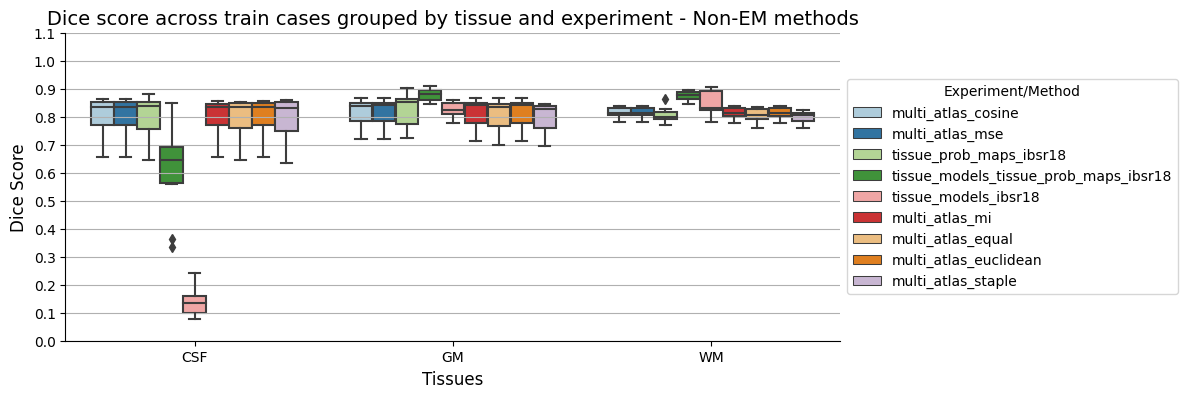

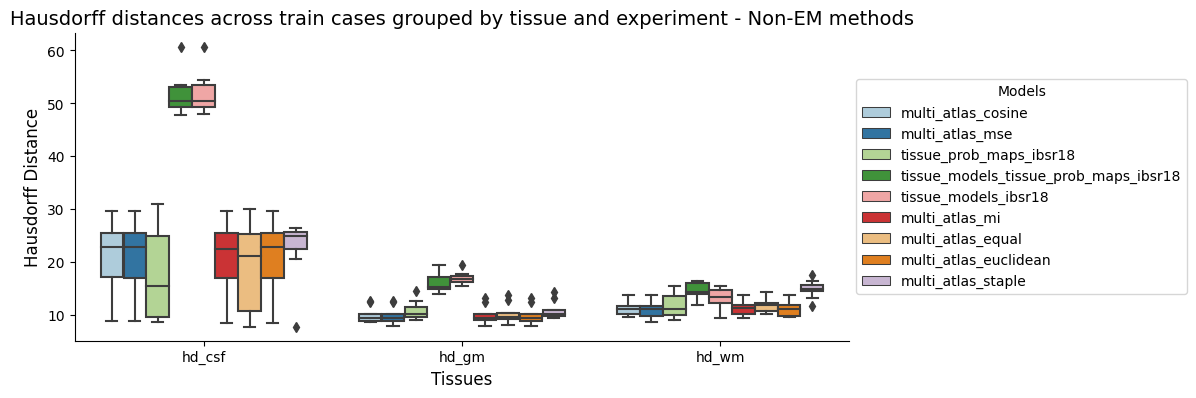

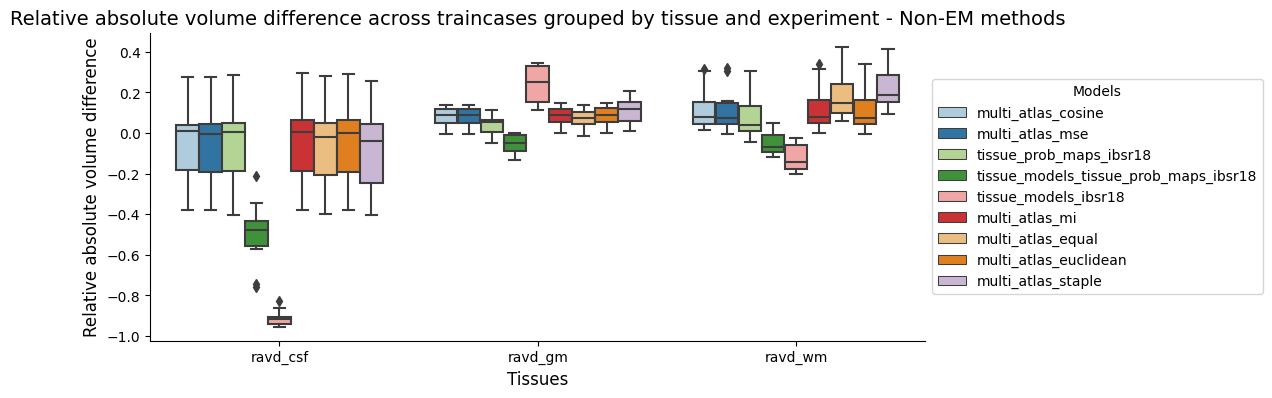

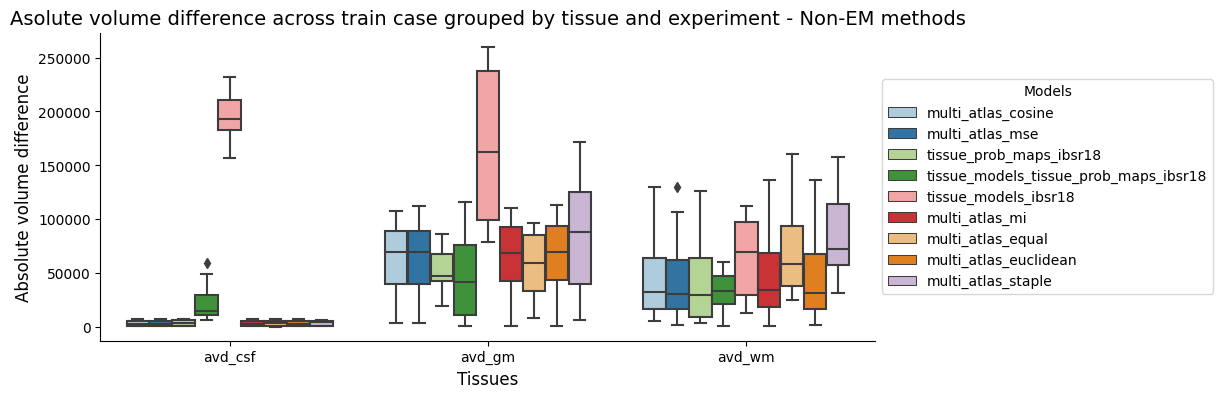

In [3]:
savepath = base_path / 'experiments/simple_segmenters'
new_results_df = pd.read_csv(savepath/'complete_metrics_simple_segmenters_train.csv', index_col=0)

# Plot dice
df = pd.melt(
    new_results_df,
    id_vars=['experiment_name', 'algorithm'],
    value_vars=['dice_csf', 'dice_gm', 'dice_wm'], ignore_index=False
)
df.variable.replace({'dice_csf': 'CSF', 'dice_gm': 'GM', 'dice_wm': 'WM'}, inplace=True)
df.columns = ['experiment_name', 'algorithm', 'tissue', 'dice']
plot_dice(df, 'train', 'Non-EM methods')
plt.savefig(savepath/'dices_train_simple_segmenters.svg', bbox_inches='tight', format='svg')
plt.show()


# Plot hausdorff
df = pd.melt(
    new_results_df,
    id_vars=['experiment_name', 'algorithm'],
    value_vars=['hd_csf', 'hd_gm', 'hd_wm'], ignore_index=False
)
df.columns = ['experiment_name', 'algorithm', 'tissue', 'hausdorff']
plot_hausorf(df, 'train', 'Non-EM methods')
plt.savefig(savepath/'hd_train_simple_segmenters.svg', bbox_inches='tight', format='svg')
plt.show()

# Plot ravd
df = pd.melt(
    new_results_df,
    id_vars=['experiment_name', 'algorithm'],
    value_vars=['ravd_csf', 'ravd_gm', 'ravd_wm'], ignore_index=False
)
df.columns = ['experiment_name', 'algorithm', 'tissue', 'ravd']
plot_ravd(df, 'train', 'Non-EM methods')
plt.savefig(savepath/'ravd_train_simple_segmenters.svg', bbox_inches='tight', format='svg')
plt.show()

# Plot avd
df = pd.melt(
    new_results_df,
    id_vars=['experiment_name', 'algorithm'],
    value_vars=['avd_csf', 'avd_gm', 'avd_wm'], ignore_index=False
)
df.columns = ['experiment_name', 'algorithm', 'tissue', 'avd']
plot_avd(df, 'train', 'Non-EM methods')
plt.savefig(savepath/'avd_train_simple_segmenters.svg', bbox_inches='tight', format='svg')
# plt.show()

#### Compute the metrics from the results for the validation set of the simple segmenters

In [5]:
# Define the paths, experiments we want and cases we want
experiments_path = base_path / 'experiments/simple_segmenters'
savepath = base_path / 'experiments/simple_segmenters'
exp_names = [
    'multi_atlas_staple',
    'multi_atlas_cosine', 'multi_atlas_mse', 'tissue_prob_maps_ibsr18', 'tissue_models_tissue_prob_maps_ibsr18',
    'tissue_models_ibsr18', 'multi_atlas_mi', 'multi_atlas_equal', 'multi_atlas_euclidean'
]


cases = ['IBSR_14', 'IBSR_17', 'IBSR_13', 'IBSR_11', 'IBSR_12']
savepath.mkdir(exist_ok=True, parents=True)
partition = 'validation'
data_path = base_path / 'data' / f'{partition}_set'
segs_path = [experiments_path / exp / 'segmentations' for exp in exp_names]

# Get results from the experiments
results_df = []
for experiment_path in experiments_path.iterdir():
    if experiment_path.is_file():
        continue
    # Compute the dices and all the remaining metrics
    experiment_name = experiment_path.name
    experiment_path = experiment_path/'segmentations'
    if experiment_name not in exp_names:
        continue
    for segm_path in tqdm(experiment_path.iterdir(), total=len(list(experiment_path.iterdir()))):
        # Get segmentation and ground truth
        case_name = segm_path.name.rstrip('.nii.gz')
        if case_name not in cases:
            continue
        gt_path = data_path / case_name / f'{case_name}_seg.nii.gz'
        segm_img = sitk.ReadImage(str(segm_path))
        segm_array = sitk.GetArrayFromImage(segm_img)
        gt_array = sitk.GetArrayFromImage(sitk.ReadImage(str(gt_path)))
        
        # Compute the metrics
        dsc = dice_score(gt_array, segm_array)
        ravd = rel_abs_vol_dif(gt_array, segm_array)
        avd_values = avd(gt_array, segm_array, segm_img.GetSpacing())
        hd = haussdorf(gt_array, segm_array, segm_img.GetSpacing())
        
        # Accumulate the results
        algo = 'simple_segmenter' if 'multi' not in experiment_name else 'multi-atlas'
        row_list = [
            experiment_name, algo, case_name, 
            dsc[0], dsc[1], dsc[2], ravd[0], ravd[1], ravd[2], avd_values[0], avd_values[1], avd_values[2], hd[0], hd[1], hd[2]
        ]
        results_df.append(row_list)

# Generate a new df
results_df = pd.DataFrame(
    results_df,
    columns=['experiment_name', 'algorithm', 'id',
             'dice_csf', 'dice_gm', 'dice_wm', 'ravd_csf', 'ravd_gm', 'ravd_wm', 'avd_csf', 'avd_gm', 'avd_wm', 'hd_csf', 'hd_gm', 'hd_wm'
             ]
)
    
# Save
results_df.to_csv(savepath/f'complete_metrics_simple_segmenters_{partition}.csv')

100%|██████████| 60/60 [00:52<00:00,  1.14it/s]


### Plot the results for the validation set of the simple segmenters

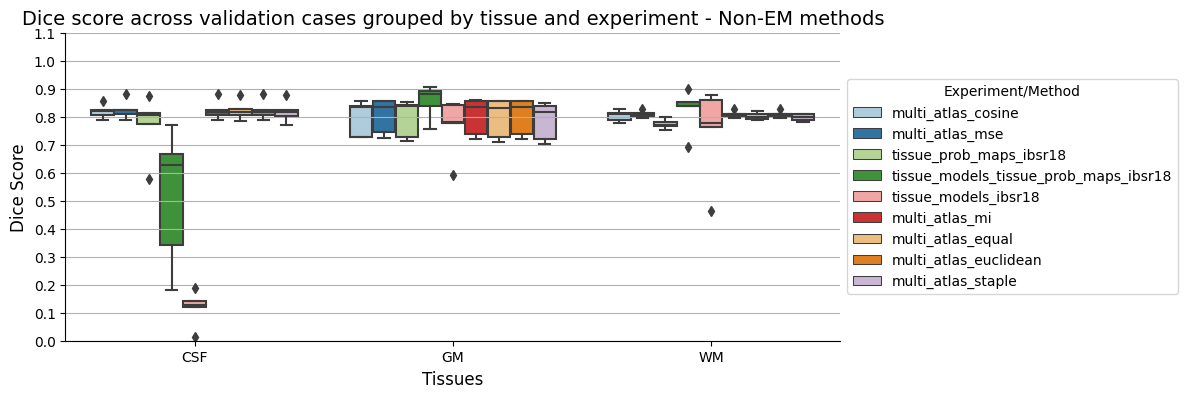

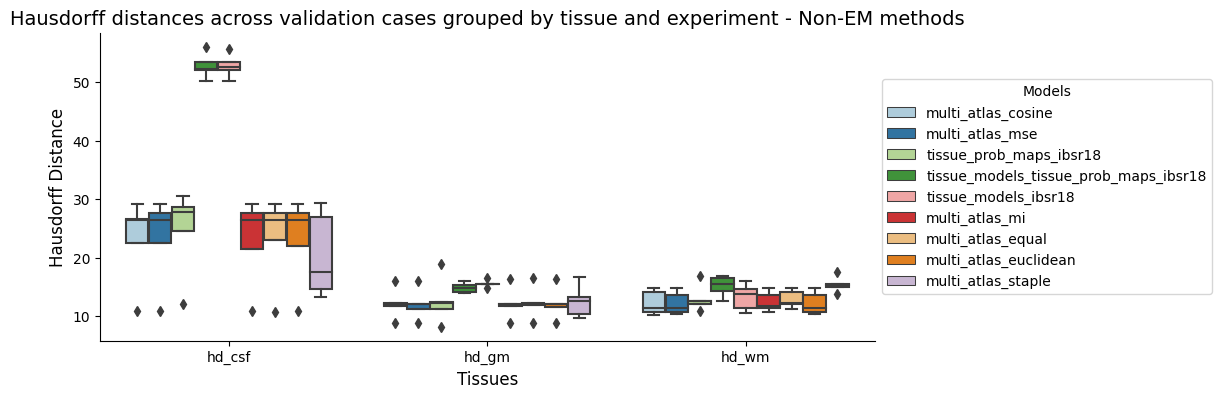

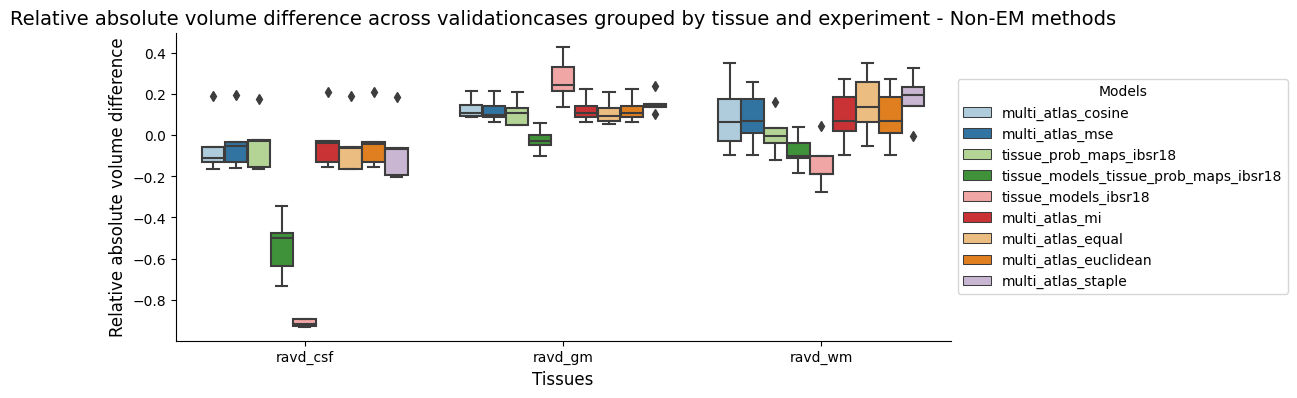

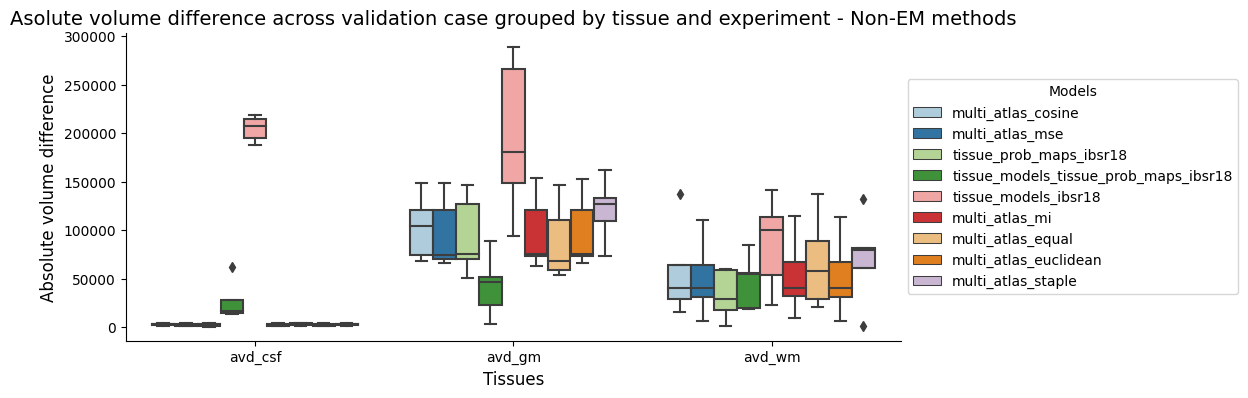

In [4]:
savepath = base_path / 'experiments/simple_segmenters'
new_results_df = pd.read_csv(savepath/'complete_metrics_simple_segmenters_validation.csv', index_col=0)

# Plot dice
df = pd.melt(
    new_results_df,
    id_vars=['experiment_name', 'algorithm'],
    value_vars=['dice_csf', 'dice_gm', 'dice_wm'], ignore_index=False
)
df.variable.replace({'dice_csf': 'CSF', 'dice_gm': 'GM', 'dice_wm': 'WM'}, inplace=True)
df.columns = ['experiment_name', 'algorithm', 'tissue', 'dice']
plot_dice(df, 'validation', 'Non-EM methods')
plt.savefig(savepath/'dices_validation_simple_segmenters.svg', bbox_inches='tight', format='svg')
# plt.show()


# Plot hausdorff
df = pd.melt(
    new_results_df,
    id_vars=['experiment_name', 'algorithm'],
    value_vars=['hd_csf', 'hd_gm', 'hd_wm'], ignore_index=False
)
df.columns = ['experiment_name', 'algorithm', 'tissue', 'hausdorff']
plot_hausorf(df, 'validation', 'Non-EM methods')
plt.savefig(savepath/'hd_validation_simple_segmenters.svg', bbox_inches='tight', format='svg')
# plt.show()

# Plot ravd
df = pd.melt(
    new_results_df,
    id_vars=['experiment_name', 'algorithm'],
    value_vars=['ravd_csf', 'ravd_gm', 'ravd_wm'], ignore_index=False
)
df.columns = ['experiment_name', 'algorithm', 'tissue', 'ravd']
plot_ravd(df, 'validation', 'Non-EM methods')
plt.savefig(savepath/'ravd_validation_simple_segmenters.svg', bbox_inches='tight', format='svg')
# plt.show()

# Plot avd
df = pd.melt(
    new_results_df,
    id_vars=['experiment_name', 'algorithm'],
    value_vars=['avd_csf', 'avd_gm', 'avd_wm'], ignore_index=False
)
df.columns = ['experiment_name', 'algorithm', 'tissue', 'avd']
plot_avd(df, 'validation', 'Non-EM methods')
plt.savefig(savepath/'avd_validation_simple_segmenters.svg', bbox_inches='tight', format='svg')
# plt.show()